# Atividade avaliativa final - Tópicos especiais em business inteligence e analytics 3

# Alunos

* Lucas Oliveira Dantas
* Newton Pereira de Paiva
* Raphael Gonçalves Silva 
* Raphael Oliveira dos Reis

## Tópicos

- Introdução
- Estudo de caso
- Importando bibliotecas
- Importando o conjunto de dados
- Preparação do texto
- Contando as palavras
- Conclusão (falta fazer)

## Introdução

O objetivo desse artigo é te ensinar a realizar a previsão dos títulos e das tags das tecnologias e linguagens de programação com base em perguntas mais frequentes criadas em 'chamados' do **GLPI**, utilizamos um conjunto de dados importados da base de dados de homologação do **Help Desk** da empresa que trabalho, lógico que "peneiramos" todos os dados sensiveis.

Criamos gráficos trazendo as top 10 pavras mais frequentes no modelo e outro gráfico com as tops 10 tags mais utilizados no modelo treinado.

* Repositório do Projeto no Github: https://github.com/LuksJobs/previsao-pln

## Estudo de caso

O **Problema de Negócio** que queremos resolver é `realizar predições das respectivas tags a partir das perguntas geradas` através da ferramenta de Help Desk da Unimed Natal: GLPI no qual faremos o treinamento do modelo através do aprendizado de máquina com algoritmo supervisionado. . 

## Importando as bibliotecas

Para nosso estudo de caso, vamos fazer uso das seguintes bibliotecas:
- **Numpy**: um pacote para computação científica.
- **Pandas**: uma biblioteca de alta-performance, fácil para manipulação de dataframes e análises de dados.
- **seaborn**: para visualizações.
- **scikit-learn**: um pacote para ferramentas para aprendizado de máquinas.
- **NLTK**: uma plataforma para trabalhar com linguagem natural.

# Instalando as dependências (Pacotes) no Linux

* ```sudo apt install python3-numpy``` - Instalação da biblioteca do **Numpy** no Python3
* ```sudo apt install python3-pandas``` - Instalação da biblioteca do **Pandas** no Python3
* ```sudo apt install python3-seaborn``` - - Instalação da biblioteca do **Seaborn** no Python3
* ```sudo apt install python3-nltk``` - Instalação da biblioteca do **NLTK** no Python3
* ```sudo apt install python3-scikit-learn``` - Instalação da biblioteca do **SCIKIT** no Python3
* ```sudo apt install python3-matplotlib``` - - Instalação da biblioteca do **MATPLOTLIB** no Python3

In [2]:
# importando as bibliotecas
import nltk
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ast import literal_eval
import re
from collections import Counter
from itertools import chain

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
#from metrics import roc_auc #deu erro na importação da biblioteca "metrics"

nltk.download('stopwords') # caso a lista esteja desatualizada

#importando as stopswords do diretório local
#stopwords = stopwords.words("portuguese", searchpath=nltk_data/corpora/stopwords)
%matplotlib inline

[nltk_data] Downloading package stopwords to /home/lucas-
[nltk_data]     dantas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Neste projeto, contaremos com 2 conjuntos de dados: **treino** (train) e **validação** (validation), no qual é composto por `títulos` e suas `tags` correspondentes (somente essas duas colunas).

## Importando o conjunto de dados

Vamos iniciar criando um função para importação dos dados. Nessa importação as *tags* são importadas entre aspas duplas, então utilizaremos a função `literal_eval` no qual converte a string em um objeto, para suprimirmos as aspas.

In [3]:
# criando a função
def read_data(filename):
    
    # importando o arquivo
    data = pd.read_csv(filename,  sep="\t")
    
    # removendo as aspas que são importadas juntas
    #data['tags'] = data['tags'].apply(literal_eval)

    # Tratamento dos valores NaN na coluna 'tags'
    data["tags"] = data["tags"].apply(lambda x: literal_eval(x) if not pd.isna(x) else [])
    
    # retornando o arquivo
    return data

Agora vamos importar os dois arquivos.

In [4]:
# importando os dados de treino
train = read_data('data/traiin.tsv')

# Imprimir o DataFrame train
#print(train.head())

# importando os dados de validação
validation = read_data('data/validatiion.tsv')

# Imprimir o DataFrame validation
#print(validation.head())

Vamos dar uma olhada nas primeiras linhas de cada conjunto com o método `head()`.

In [5]:
# visualizando as primeiras 10 linhas do conjunto de arquivos treinandos
train.head(10)

,title,tags
0,Como desenhar um gráfico de pontos empilhados ...,[r]
1,selecionar todos os registros do MySQL onde um...,"[php, mysql]"
2,Como encerrar um aplicativo do Windows Phone 8.1,[c#]
3,obter a hora atual em um país específico via j...,"[javascript, jquery]"
4,Configurando o Tomcat para usar SSL,[java]
5,Plugin Awesome Nested Set - como adicionar nov...,[ruby-on-rails]
6,Como criar um mapa a partir de uma resposta JS...,"[ruby, ruby-on-rails-3, json]"
7,testar rspec se o método é chamado,[ruby]
8,Exceção SpringBoot Catalina LifeCycle,"[java, spring, spring-mvc]"
9,Como importar dados do Excel para um banco de ...,"[php, codeigniter]"


In [6]:
# visualizando as primeiras 10 linhas do conjunto de arquivos validados
validation.head(10)

,title,tags
0,Por que o odbc_exec sempre falha?,"[php, sql]"
1,Acessar uma variável de classes base de dentro...,[javascript]
2,"Content-Type ""application/json"" não é obrigató...","[ruby-on-rails, ruby]"
3,Sessões no Sinatra: Usadas para Passar Variáveis,"[ruby, session]"
4,"Recebendo erro - tipo ""json"" não existe - no P...","[ruby-on-rails, ruby, json]"
5,biblioteca não encontrada para.....?,"[c++, iphone, ios, xcode]"
6,Arquivo .csproj - Adição/Exclusão programática...,[c#]
7,TypeError: makedirs() recebeu um argumento de ...,"[python, django]"
8,Como Pan um div usando JQuery,"[javascript, jquery, html]"
9,Tutoriais intermediários/avançados do Hibernate,"[java, hibernate]"


Podemos notar que temos aspas, underlines, dois pontos, traços na coluna **title** e a coluna **tags** não tem uma quantidade fixa de palavras, além de cada termo está em formato de lista.

Vamos agora dar uma olhada na dimensão desses dados em quantidade de linhas e colunas:

In [7]:
# visualizando as dimensões em quantidade de linhas e colunas dos dados de treino;
print(f"Os dados de TREINO possui:")
print(f"{train.shape[0]} linhas")
print(f"{train.shape[1]} colunas\n")

# visualizando as dimensões em quantidade de linhas e colunas dos dados de treino;
print(f"Os dados de VALIDAÇÃO possui:")
print(f"{validation.shape[0]} linhas")
print(f"{validation.shape[1]} colunas")

Os dados de TREINO possui:
55 linhas
2 colunas

Os dados de VALIDAÇÃO possui:
55 linhas
2 colunas


Observamos que o conjunto de validação corresponde à 30% do conjunto de treino, um número bom para utilizarmos como validação do nosso modelo.

Vamos então, separar nossa variável `preditora` (coluna **title**) da nossa variável `alvo` (coluna **tags**), em ambos os conjuntos, utilizaremos o método `values`.

In [8]:
# separando os dados de treino
X_train, y_train = train['title'].values, train['tags'].values

# separando os dados de validação
X_val, y_val = validation['title'].values, validation['tags'].values

Os arquivos viraram uma lista, no qual cada linha se tornou um elemento dessa lista, vamos dar uma olhada para entendermos melhor no *X_train*, as outras seguem da mesma forma.

In [9]:
# visualizando X_train
X_train

array(['Como desenhar um gráfico de pontos empilhados no R?',
       'selecionar todos os registros do MySQL onde um campo de data e hora é menor que um valor especificado',
       'Como encerrar um aplicativo do Windows Phone 8.1',
       'obter a hora atual em um país específico via jQuery',
       'Configurando o Tomcat para usar SSL',
       'Plugin Awesome Nested Set - como adicionar novos filhos à árvore em vários níveis',
       'Como criar um mapa a partir de uma resposta JSON no Ruby on Rails 3?',
       'testar rspec se o método é chamado',
       'Exceção SpringBoot Catalina LifeCycle',
       'Como importar dados do Excel para um banco de dados MySQL usando PHP',
       'Obtendo o objeto java.lang.Class<T> para um tipo parametrizado sem construir a classe em q_uestion?',
       'iPad não seleciona todo o texto dentro de uma entrada de texto ao tocar',
       'Como o $ do jQuery é uma função e um objeto?',
       'Eclipse C++ MinGW - Não é possível iniciar o programa <Termin

Em geral, quando trabalhamos com Processamento de Linguagem Natural, os **dados são desestruturados**, como podemos notar também nesse documento. **Devemos analisar com cautela** e escolher a melhor forma que não irá descaracterizar o sentido ou a palavra do que estamos tratando.

Vamos criar uma função para tratar nossos dados, removendo **símbolos** e **caracteres especiais** e também as **stopwords**, que são palavras que aparecem muitas vezes mas que não agregam valor ao nosso objetivo e se mantivermos podem causar ruidos e não termos uma boa precisão nas previsões.

## Preparação do texto

Nesta etapa vamos começar a "limpar" nosso texto, removendo tudo que não tem valor para nosso objetivo.

Vamos iniciar criando uma função para isso, fazendo uso do pacote `re`, *Regular Expression Operations* e com ela podemos utilizar dos recursos do REGEX.

Faremos uso do método *compile* (`re.compile`), dentro de um objeto, para compilar a *expressão regular* que queremos, com isso quando a função encontrar essa expressão no texto, ele a removerá. Podemos utilizar para remover caracteres especiais, números, entre outros padrões existentes. Depois usaremos esse objeto como uma função com o método `sub`, passando como parâmetros o que irá substituir e o conjunto de dados.

In [10]:
# criando os objetos com as expressões regulares
remove_espec_carac = re.compile('[/(){}\[\]\|@,;]')
remove_symb = re.compile('[^0-9a-z #+_]')

# criando um objeto para remoção de stopwords no idioma ingles
stopwords = stopwords.words('portuguese')

# criando a função
def text_prepare(text):
    
    # normalizando nosso texto em letras minúsculas, assim facilita nossa preparação
    text = text.lower()
    
    # substituindo caracteres especiais por espaços em branco
    text = remove_espec_carac.sub(' ', text)
    
    # retornando apenas letras e números
    text = remove_symb.sub('', text)
    
    # removendo as stopwords
    text = ' '.join(word for word in text.split() if word not in stopwords)
    
    # retornando o texto modificado
    return text

Para verificarmos se nossa função de preparação está funcionando, vamos criar um pequeno texto com as informações que queremos remover e analisar.

In [11]:
# Criando a função
def test_text_prepare():
    
    # definindo os exemplos
    examples = ["SQL Server - algum equivalente à função CHOOSE do Excel?",
                "Como liberar vetor de memória c++<int> * arr?"]
    
    # inserindo a resposta correta
    answers = ["equivalente do sql server excede a função de escolha", 
               "vetor de memória c ++ livre arr"]
    
    # Aplicando um loop e comparando a limpeza
    for ex, ans in zip(examples, answers):
        
    # condições para retornar se o resultado foi aprovado ou reprovado
        if text_prepare(ex) != ans:
            return "Resposta incorreta para: '%s'" % ex
    return 'Testes básicos aprovados.'

In [12]:
# rodando a função de teste
print(test_text_prepare())

Resposta incorreta para: 'SQL Server - algum equivalente à função CHOOSE do Excel?'


Nossa função passou no teste! Agora podemos pré-processar os *titles* usando a função **text_prepare** para os conjuntos de dados de treino e validação.

In [13]:
# aplicando a função nos dados de treino
X_train = [text_prepare(x) for x in X_train]

# aplicando a função nos dados de validação
X_val = [text_prepare(x) for x in X_val]

Vamos dar uma olhada nas primeiras linhas, mas que na verdade são elementos porque estão contidos em uma lista e não mais como um dataframe.

In [13]:
# visualizando os 10 primeiros elementos
X_train[:10]

['desenhar grfico pontos empilhados r',
 'selecionar todos registros mysql onde data hora menor valor especificado',
 'encerrar aplicativo windows phone 81',
 'hora atual pas especfico via jquery',
 'configurando tomcat ssl',
 'plugin awesome nested set adicionar novos filhos rvore vrios nveis',
 'criar mapa partir resposta json ruby on rails 3',
 'testar rspec mtodo chamado',
 'exceo springboot catalina lifecycle',
 'importar excel banco mysql php',
 'obtendo objeto javalangclasst tipo parametrizado construir classe q_uestion',
 'ipad seleciona todo texto dentro entrada texto tocar',
 'jquery funo objeto',
 'eclipse c++ mingw possvel iniciar programa terminado',
 'javascript posso chamar mtodo prottipo outro mtodo prottipo',
 'interseo lista conjuntos',
 'possvel ocultar teclado durante viewwilldisappear ios7',
 'buscar chave json swift',
 'alterar modelo cabealho pivot windows phone 8',
 'criptografia connectionstring',
 'permitir interface usurio atualizada durante operao ui demorad

## Contando as palavras

Seguindo aqui com nosso texto "limpo", podemos calcular as quantidades de ocorrência de cada palavra nos conjuntos de treino. Vamos utilizar a função `Counter` do pacote `Collections` para fazer contagem e a função `chain` do pacote `itertools` que nos fornece um *loop* que irá iterar as palavras com suas respectivas frequencias. 

In [14]:
# realizando a contagem e inserindo em um dicionário
words_counts = Counter(chain.from_iterable([i.split(" ") for i in X_train]))

# ordenando do maior para o menor
words_freq = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)

Vamos dar uma olhada no nas perguntas mais frequentes em uma escala de **TOP 10**, ou seja, as 10 palavras que mais apareceram.

In [18]:
words_freq[:10]

[('jquery', 5),
 ('ruby', 5),
 ('java', 4),
 ('mysql', 3),
 ('windows', 3),
 ('especfico', 3),
 ('json', 3),
 ('mtodo', 3),
 ('objeto', 3),
 ('possvel', 3),
 ('javascript', 3),
 ('python', 3),
 ('erro', 3),
 ('r', 2),
 ('selecionar', 2),
 ('todos', 2),
 ('hora', 2),
 ('aplicativo', 2),
 ('phone', 2),
 ('criar', 2),
 ('partir', 2),
 ('excel', 2),
 ('banco', 2),
 ('php', 2),
 ('tipo', 2),
 ('texto', 2),
 ('funo', 2),
 ('programa', 2),
 ('posso', 2),
 ('prottipo', 2),
 ('ocultar', 2),
 ('durante', 2),
 ('alterar', 2),
 ('modelo', 2),
 ('8', 2),
 ('sada', 2),
 ('2', 2),
 ('consulta', 2),
 ('linq', 2),
 ('rtulo', 2),
 ('objetos', 2),
 ('atributo', 2),
 ('c#', 2),
 ('string', 2),
 ('ajax', 2),
 ('conexo', 2),
 ('matriz', 2),
 ('desenhar', 1),
 ('grfico', 1),
 ('pontos', 1)]

Vamos visualizar em forma de gráfico, pois ficará mais visível e intuitivo, utilizando um `barplot` para visualizar.

Mas teremos que mudar o formato antes, pois como o resultado é uma tupla, vamos converter em um dicionário, separar e deixar as palavras em uma lista, assim como as ocorrências, separar e colocar também em outra lista.

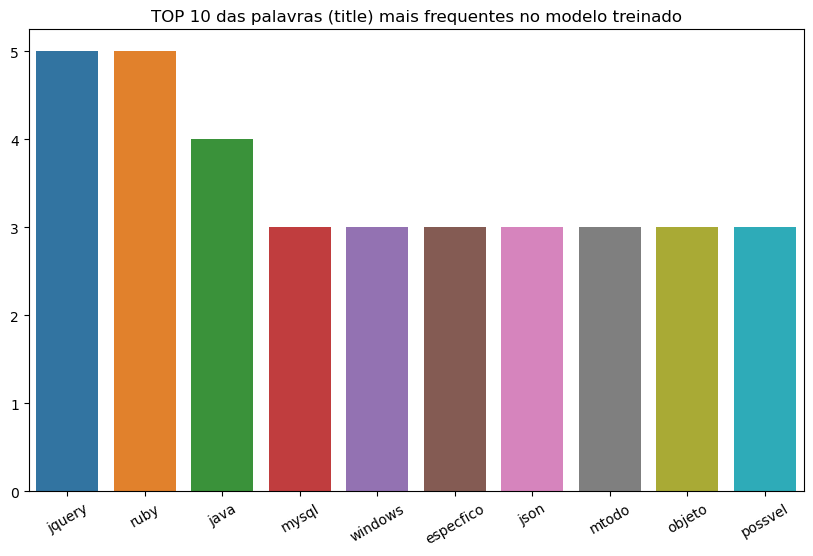

In [16]:
# colocando as palavras em um objeto do tipo lista
words_list = list(dict(words_freq[:10]).keys())

# colocando as ocorrências em um objeto do tipo lista
occur_list = list(dict(words_freq[:10]).values())

# definindo a área de plotagem
plt.figure(figsize=(10,6))

# criando o gráfico
ax = sns.barplot(x = words_list, y = occur_list)

# inserindo o título
ax.set_title('TOP 10 das palavras (title) mais frequentes no modelo treinado')

# rotacionando os rótulos do eixo x
plt.xticks(rotation=30);

A palavra **arquivo** é a que mais aparece, acredito que seja a palavra mais usada na maioria das perguntas que são sobre "como funciona" algo, em seguida entram algumas linguagens de programação, assim como buscas por erros.

Da mesma forma vamos fazer todo esse processo de contagem para as tags.

In [235]:
# realizando a contagem e inserindo em um dicionário
tags_counts = Counter(chain.from_iterable([i for i in y_train]))

# ordenando do maior para o menor
tags_freq = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)

Vamos também dar uma olhada no **TOP 10**, as 10 tags que mais apareceram.

In [236]:
tags_freq[:10]

[('c#', 11),
 ('javascript', 10),
 ('java', 10),
 ('jquery', 8),
 ('python', 7),
 ('php', 6),
 ('ruby', 4),
 ('json', 4),
 ('mysql', 3),
 ('ios', 3)]

Visualizando graficamente as **TOP 10** tags mais frequentes no modelo treinado.

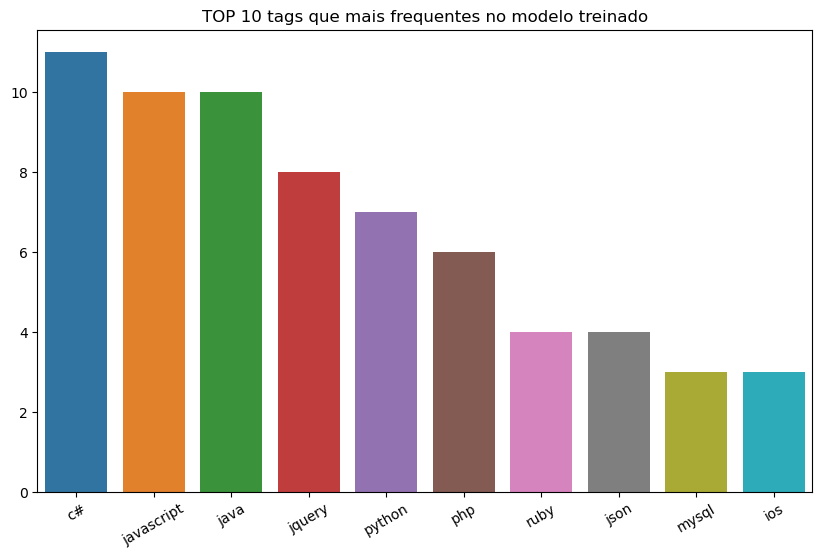

In [237]:
# colocando as palavras em um objeto do tipo lista
tags_list = list(dict(tags_freq[:10]).keys())

# colocando as ocorrências em um objeto do tipo lista
occur_list = list(dict(tags_freq[:10]).values())

# definindo a área de plotagem
plt.figure(figsize=(10,6))

# criando o gráfico
ax = sns.barplot(x = tags_list, y = occur_list)

# inserindo o título
ax.set_title('TOP 10 (tags) que são mais frequentes no modelo treinado')

# rotacionando os rótulos do eixo x
plt.xticks(rotation=30);

As tags que mais aparecem são linguagens de Programação, no qual são relacionadas com as perguntas, sobre o *uso* ou *erros* contidos nas perguntas, por exemplo.

## Conclusão